# Examples for the AbsComponent Class (v0.3)

In [1]:
%matplotlib inline

# suppress warnings for these examples
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import
try:
    import seaborn as sns; sns.set_style("white")
except:
    pass

import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.isgm import utils as ltiu
from linetools.analysis import absline as laa
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent


#
import imp
lt_path = imp.find_module('linetools')[1]

## Instantiate

### Standard

In [3]:
abscomp = AbsComponent((10.0*u.deg, 45*u.deg), (14,2), 1.0, [-300,300]*u.km/u.s)
abscomp

<AbsComponent: 00:40:00 +45:00:00, Name=SiII_z1.00000, Zion=(14,2), Ej=0 1 / cm, z=1, vlim=-300 km / s,300 km / s>

### From AbsLines

#### From one line

In [4]:
lya = AbsLine(1215.670*u.AA)
lya.analy['vlim'] = [-300.,300.]*u.km/u.s
lya.attrib['z'] = 2.92939

linetools.lists.parse: Reading linelist --- 
   /Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/data/lines/morton03_table2.fits.gz
linetools.lists.parse: Reading linelist --- 
   /Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/data/lines/morton00_table2.fits.gz
linetools.lists.parse: Reading linelist --- 
   /Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/data/lines/verner96_tab1.fits.gz
linetools.lists.parse: Reading linelist --- 
   /Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/data/lines/verner94_tab6.fits
linetools.lists.parse: Reading linelist --- 
   /Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/data/lines/EUV_lines.ascii
read_sets: Using set file -- 
  /Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/lists/sets/llist_v1.0.ascii


In [5]:
abscomp = AbsComponent.from_abslines([lya])
print(abscomp)
abscomp._abslines

<AbsComponent: 00:00:00 +00:00:00, Name=HI_z2.92939, Zion=(1,1), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,300 km / s>


[<AbsLine: HI 1215, wrest=1215.6700 Angstrom>]

#### From multiple

In [6]:
lyb = AbsLine(1025.7222*u.AA)
lyb.analy['vlim'] = [-300.,300.]*u.km/u.s
lyb.attrib['z'] = lya.attrib['z']

In [7]:
abscomp = AbsComponent.from_abslines([lya,lyb])
print(abscomp)
abscomp._abslines

<AbsComponent: 00:00:00 +00:00:00, Name=HI_z2.92939, Zion=(1,1), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,300 km / s>


[<AbsLine: HI 1215, wrest=1215.6700 Angstrom>,
 <AbsLine: HI 1025, wrest=1025.7222 Angstrom>]

## Methods

### Generate a Component Table

In [8]:
import imp
imp.reload(laa)
lya.attrib['logN'] = 14.1
lya.attrib['sig_logN'] = 0.15
lya.attrib['flag_N'] = 1
laa.linear_clm(lya.attrib)
lyb.attrib['logN'] = 14.15
lyb.attrib['sig_logN'] = 0.19
lyb.attrib['flag_N'] = 1
laa.linear_clm(lyb.attrib)

(<Quantity 141253754462275.53 1 / cm2>, <Quantity 61797269977312.6 1 / cm2>)

In [9]:
abscomp = AbsComponent.from_abslines([lya,lyb])
comp_tbl = abscomp.build_table()
comp_tbl

wrest,z,flag_N,logN,sig_logN
Angstrom,,,,
float64,float64,int64,float64,float64
1215.67,2.92939,1,14.1,0.15
1025.7222,2.92939,1,14.15,0.19


### Synthesize multiple components

In [10]:
SiIItrans = ['SiII 1260', 'SiII 1304', 'SiII 1526']
SiIIlines = []
for trans in SiIItrans:
    iline = AbsLine(trans)
    iline.attrib['logN'] = 12.8 + np.random.rand()
    iline.attrib['sig_logN'] = 0.15
    iline.attrib['flag_N'] = 1
    iline.attrib['z'] = 2.92939
    iline.analy['vlim'] = [-300.,50.]*u.km/u.s
    _,_ = laa.linear_clm(iline.attrib)
    SiIIlines.append(iline)
SiIIcomp = AbsComponent.from_abslines(SiIIlines)
SiIIcomp.synthesize_colm()

In [11]:
SiIIlines2 = []
for trans in SiIItrans:
    iline = AbsLine(trans)
    iline.attrib['logN'] = 13.3 + np.random.rand()
    iline.attrib['sig_logN'] = 0.15
    iline.attrib['flag_N'] = 1
    iline.attrib['z'] = 2.92939
    iline.analy['vlim'] = [50.,300.]*u.km/u.s
    _,_ = laa.linear_clm(iline.attrib)
    SiIIlines2.append(iline)
SiIIcomp2 = AbsComponent.from_abslines(SiIIlines2)
SiIIcomp2.synthesize_colm()

In [12]:
abscomp.synthesize_colm()
[abscomp,SiIIcomp,SiIIcomp2]

[<AbsComponent: 00:00:00 +00:00:00, Name=HI_z2.92939, Zion=(1,1), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,300 km / s, logN=14.1172, sig_N=0.117912, flag_N=1>,
 <AbsComponent: 00:00:00 +00:00:00, Name=SiII_z2.92939, Zion=(14,2), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,50 km / s, logN=13.1121, sig_N=0.0893676, flag_N=1>,
 <AbsComponent: 00:00:00 +00:00:00, Name=SiII_z2.92939, Zion=(14,2), Ej=0 1 / cm, z=2.92939, vlim=50 km / s,300 km / s, logN=13.4314, sig_N=0.0948459, flag_N=1>]

In [13]:
synth_SiII = ltiu.synthesize_components([SiIIcomp,SiIIcomp2])
synth_SiII

<AbsComponent: 00:00:00 +00:00:00, Name=SiII_z2.92939, Zion=(14,2), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,300 km / s, logN=13.6015, sig_N=0.0703485, flag_N=1>

### Generate multiple components from abslines

In [14]:
imp.reload(ltiu)
comps = ltiu.build_components_from_abslines([lya,lyb,SiIIlines[0],SiIIlines[1]])
comps

[<AbsComponent: 00:00:00 +00:00:00, Name=HI_z2.92939, Zion=(1,1), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,300 km / s>,
 <AbsComponent: 00:00:00 +00:00:00, Name=SiII_z2.92939, Zion=(14,2), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,50 km / s>]

### Generate an Ion Table

In [15]:
imp.reload(ltiu)
tbl = ltiu.iontable_from_components([abscomp,SiIIcomp,SiIIcomp2])
tbl

Z,ion,A,Ej,z,vmin,vmax,flag_N,logN,sig_logN
,,,,,km / s,km / s,,,
int64,int64,int64,float64,float64,float64,float64,int64,float64,float64
1,1,0,0.0,2.92939,-300.0,300.0,1,14.1172024817,0.117911610801
14,2,0,0.0,2.92939,-300.0,300.0,1,13.6015026841,0.070348495532


### Stack plot

#### Load a spectrum

In [16]:
xspec = lsio.readspec(lt_path+'/spectra/tests/files/UM184_nF.fits')
lya.analy['spec'] = xspec
lyb.analy['spec'] = xspec

#### Show

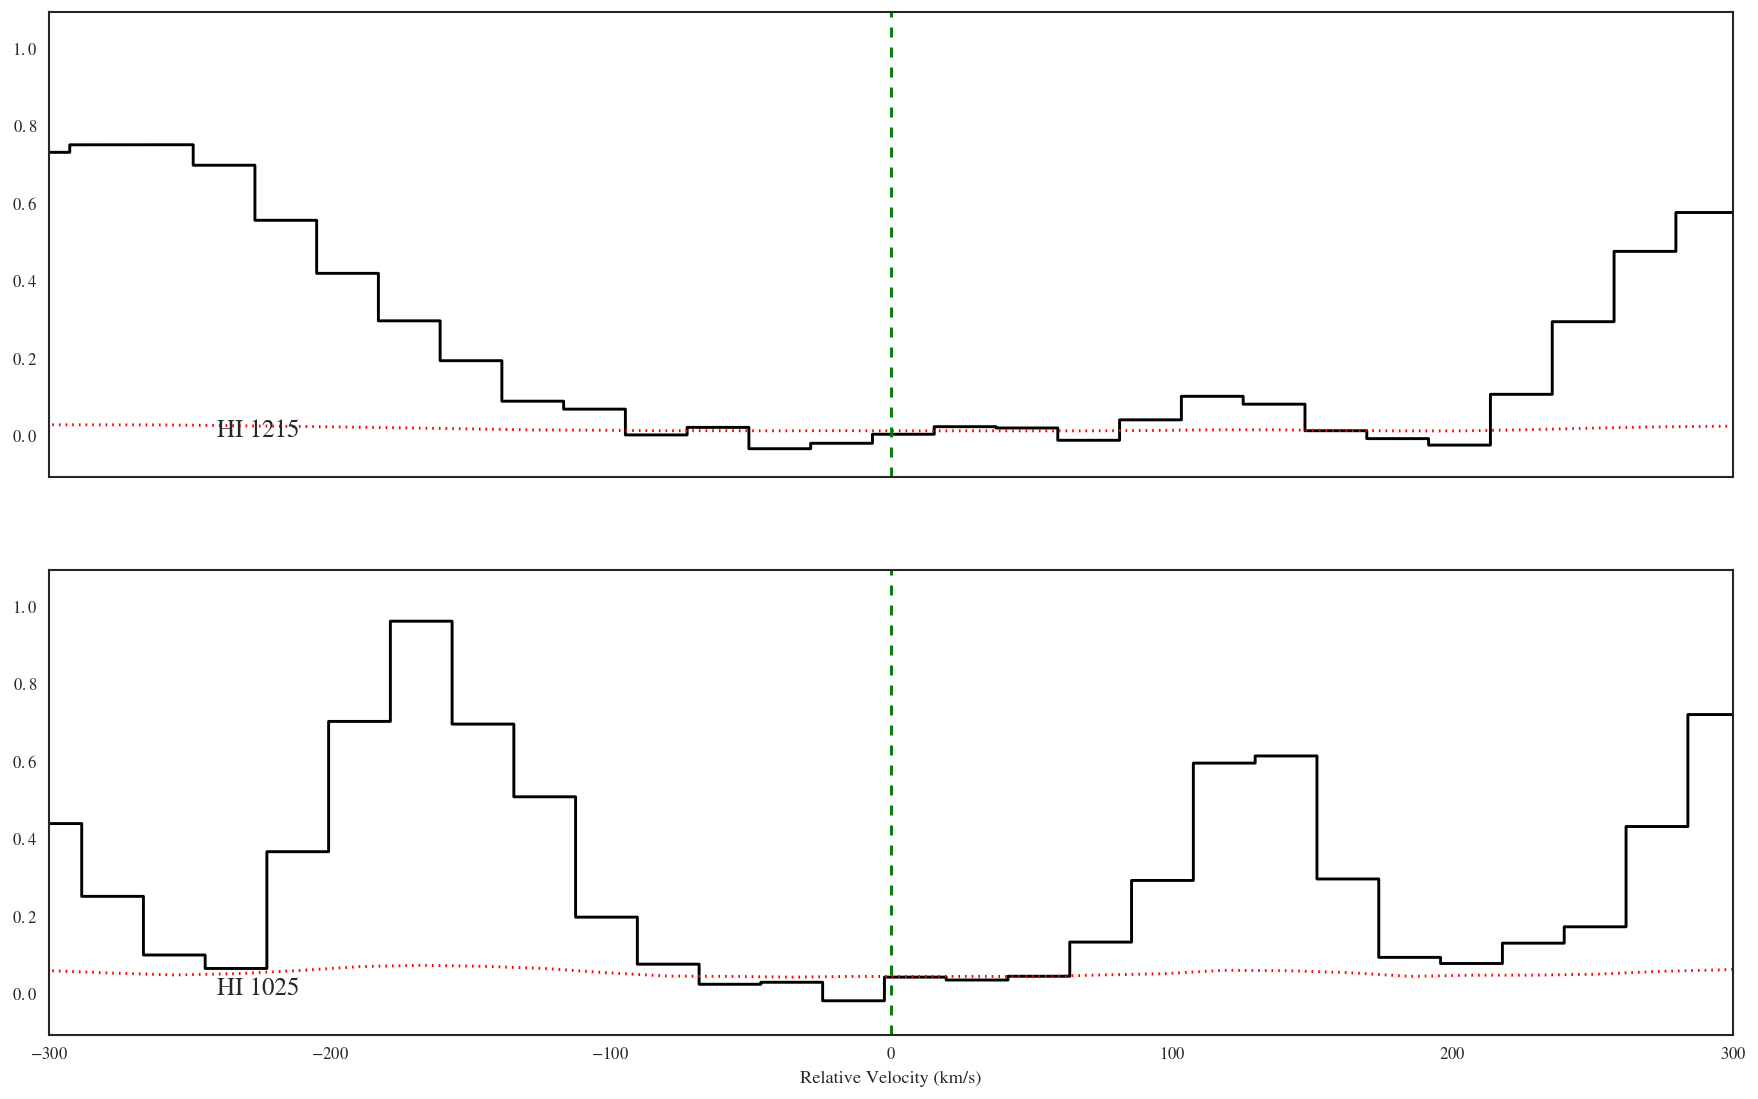

In [17]:
abscomp = AbsComponent.from_abslines([lya,lyb])
abscomp.stack_plot()